In [2]:
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using Random
using AbstractAlgebra
using Quantikz: displaycircuit
using Statistics
using StatsBase
using DataFrames
using ReinforcementLearning
using Flux
using Flux.Losses: huber_loss
using ClosedIntervals
using Zygote
using ComponentArrays
using StableRNGs
using QuantumClifford.Experimental.NoisyCircuits: applyop!, affectedqubits, applyop_branches
using Plots

In [3]:
include("environment.jl")

# CircuitEnv

## Traits

| Trait Type        |                Value |
|:----------------- | --------------------:|
| NumAgentStyle     |        SingleAgent() |
| DynamicStyle      |         Sequential() |
| InformationStyle  | PerfectInformation() |
| ChanceStyle       |      Deterministic() |
| RewardStyle       |     TerminalReward() |
| UtilityStyle      |         GeneralSum() |
| ActionStyle       |   MinimalActionSet() |
| StateStyle        |   Observation{Any}() |
| DefaultStateStyle |   Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval}}(ClosedInterval[[0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]])`

## Action Space

`Base.OneTo(115)`

## Current State

```
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```


In [4]:
env=CircuitEnv(
        initial_pairs = 3,
        net_noise = 0.1,
        local_noise = 0.01,
        entanglement_type = :bell,
        max_len=6
)

# CircuitEnv

## Traits

| Trait Type        |                Value |
|:----------------- | --------------------:|
| NumAgentStyle     |        SingleAgent() |
| DynamicStyle      |         Sequential() |
| InformationStyle  | PerfectInformation() |
| ChanceStyle       |      Deterministic() |
| RewardStyle       |     TerminalReward() |
| UtilityStyle      |         GeneralSum() |
| ActionStyle       |   MinimalActionSet() |
| StateStyle        |   Observation{Any}() |
| DefaultStateStyle |   Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval}}(ClosedInterval[[0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]])`

## Action Space

`Base.OneTo(115)`

## Current State

```
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```


In [5]:
RLBase.test_runnable!(env)

Test Summary:                 | Pass  Total
random policy with CircuitEnv | 2000   2000


Test.DefaultTestSet("random policy with CircuitEnv", Any[], 2000, false, false)

In [6]:
function bandit_testbed(
    ;max_len=5,
    initial_pairs=3,
    warmup_steps = 20,
    δ = 0.85,
    ϵ_stable = 0.0001,
    kind = :linear, # :exp or :linear
    decay_steps = 1000,
    stop_after_episode = 1000,
    batch_size = 32,
    trajectories = 500,
    optimizer = ADAM()
)
    env = CircuitEnv(;max_len=max_len,initial_pairs=initial_pairs,trajectories = trajectories)
    ns, na = length(RLBase.state(env)), length(action_space(env))
    agent = Agent(
               policy = QBasedPolicy(
                   learner = BasicDQNLearner(
                       approximator = NeuralNetworkApproximator(
                           model = Chain(
                               Dense(ns, 128, relu; init = glorot_uniform),
                               Dense(128, 128, relu; init = glorot_uniform),
                               Dense(128, na; init = glorot_uniform),
                           ) |> cpu,
                           optimizer = optimizer,
                       ),
                       batch_size = batch_size,
                       min_replay_history = 100,
                       loss_func = huber_loss,
                   ),
                   explorer = MyExplorer1(
                       warmup_steps = warmup_steps,
                       δ = δ,
                       N = initial_pairs,
                       kind = kind,
                       ϵ_stable = ϵ_stable,
                       decay_steps = decay_steps,
                   ),
               ),
               trajectory = CircularArraySARTTrajectory(
                   capacity = 500, 
                   state = Vector{Float32} => (ns,),
                   action = Int => (),
                   reward = Float32 => (),
                   terminal = Bool => (),
               ),
           )
    h1 = MyHook(;)
    h2 = TotalRewardPerEpisode(;is_display_on_exit=false)
    h3 = RewardsPerEpisode()
    h4 = StepsPerEpisode()
    run(agent, env, StopAfterEpisode(stop_after_episode), ComposedHook(h1, h2, h3, h4))
    return h1.fidelity, h2.rewards, h1.finalcircuit, agent
end

bandit_testbed (generic function with 1 method)

In [7]:
df_f=DataFrame()
df_r=DataFrame()
for ϵ_stable in [0,0.0001]
    for batch_size in [32,64]
        for trajectories in [500,1000]
            fidelity,reward,_,_=bandit_testbed(;
                decay_steps = 800, 
                stop_after_episode = 500,
                warmup_steps = 200,
                batch_size = batch_size,
                trajectories = trajectories,
                ϵ_stable = ϵ_stable
            )
            df1=DataFrame(iteration=collect(1:length(fidelity)), fidelity=fidelity,
                batch_size=fill(batch_size, length(fidelity)), 
                trajectories=fill(trajectories, length(fidelity)), 
                ϵ_stable=fill(ϵ_stable, length(fidelity)))
            df2=DataFrame(iteration=collect(1:length(reward)), reward=reward,
                batch_size=fill(batch_size, length(reward)), 
                trajectories=fill(trajectories, length(reward)), 
                ϵ_stable=fill(ϵ_stable, length(reward)))
            append!(df_f,df1)
            append!(df_r,df2)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:59
Progress: 100%|█████████████████████████████████████████| Time: 0:06:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:02:50
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
Progress: 100%|█████████████████████████████████████████| Time: 0:01:37
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


## plots of fidelities

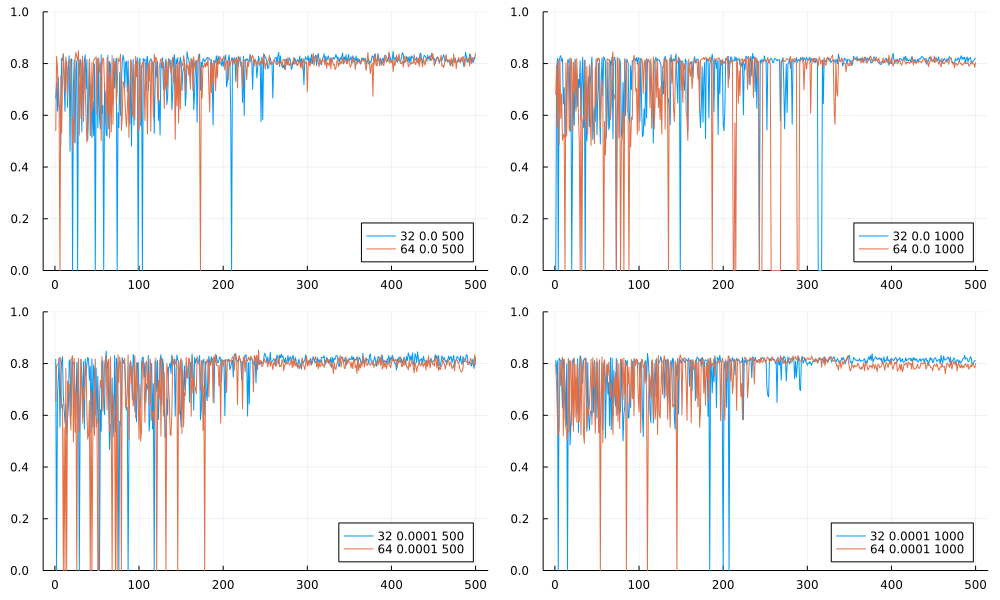

In [12]:
using StatsPlots
@df df_f plot(:iteration, :fidelity, ylim=(0,1), legend=:bottomright, size=(1000,600), group=(:batch_size,:ϵ_stable,:trajectories), layout=(2,2))

## plots of rewards

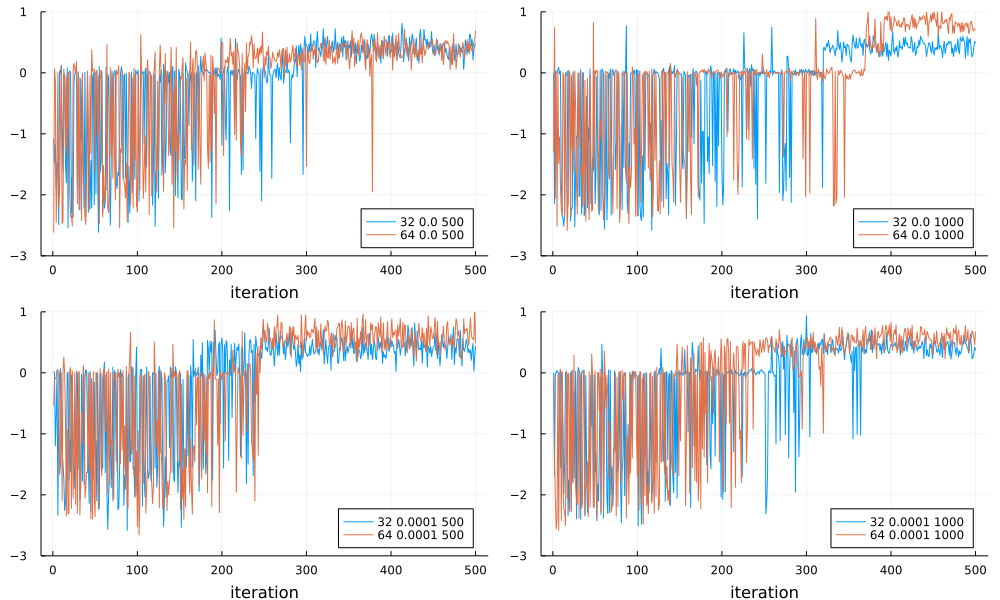

In [14]:
@df df_r plot(:iteration, :reward, ylim=(-3,1), legend=:bottomright, xlabel="iteration", size=(1000,600), group=(:batch_size,:ϵ_stable,:trajectories), layout=(2,2))